# Generate Polylla mesh

In [1]:
from mesh import TetrahedronMesh
from PolyllaEdge import PolyllaEdge
from PolyllaFace import PolyllaFace

numVertices = 500

# Semiuniform Polylla

In [2]:
filename = "data/"+ str(numVertices) + "uniform.1"
outputname = "data/"+ str(numVertices) + "uniform"

node_file = filename + ".node"
ele_file = filename + ".ele"
face_file = filename + ".face"
edge_file = filename + ".edge"

mesh = TetrahedronMesh(node_file, face_file, ele_file, edge_file)

polyllaEdge_mesh = PolyllaEdge(mesh)
polyllaFace_mesh = PolyllaFace(mesh)

mesh.get_info()
polyllaEdge_mesh.get_info()
polyllaFace_mesh.get_info()


reading node file: data/500uniform.1.node
reading face file: data/500uniform.1.face
reading ele file: data/500uniform.1.ele
reading edge file: data/500uniform.1.edge
Tetrahedral mesh info:
Number of nodes:  512
Number of faces:  4410
Number of tetrahedrons:  2058
Number of edges:  2863
PolyllaEdge info:
Number of polyhedrons: 343
Number of barrier-edges: 0
Number of hanging polyhedrons: 3780.0
Number of polyhedrons that are tetrahedrons: 0
PolyllaFace info:
Number of polyhedrons: 572
Number of barrier faces: 247
Number of polyhedra with barrier faces: 141
Number of polyhedrons that are tetrahedrons: 163


## Plot Polylla mesh

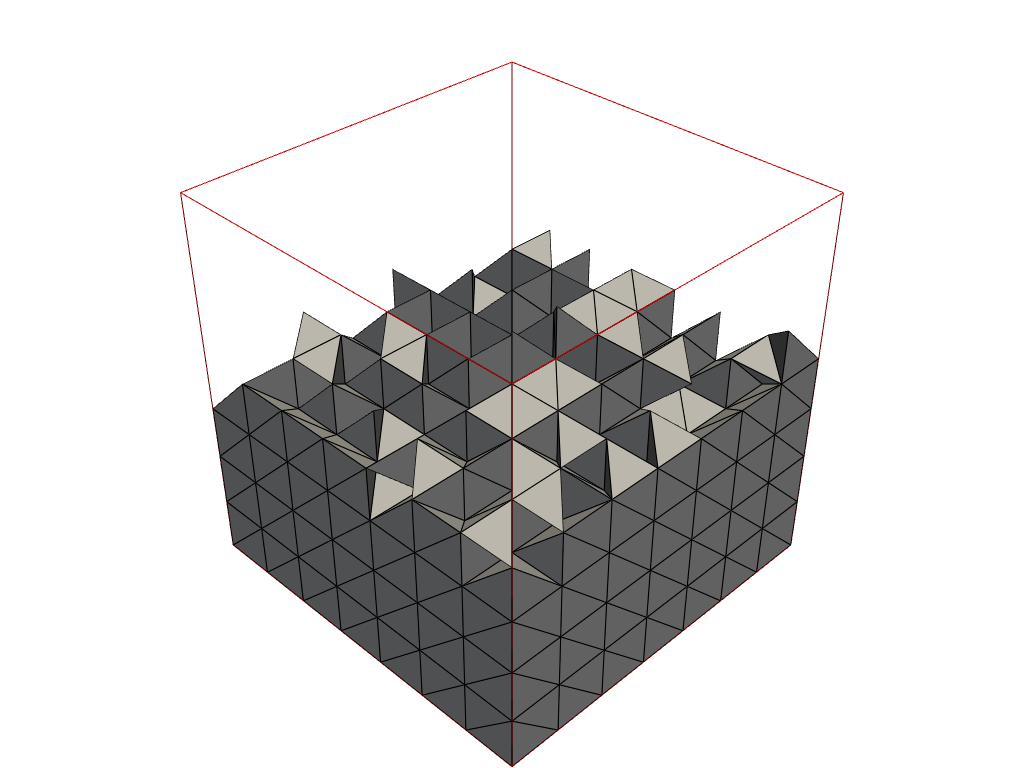

In [4]:
import numpy as np
import pyvista as pv

polyhedral_mesh = polyllaFace_mesh.polyhedral_mesh

list_of_cells = []

face_list = polyllaFace_mesh.mesh.face_list
node_list = polyllaFace_mesh.mesh.node_list

polyhedral_list = []
for poly in polyhedral_mesh:
    nFaces = len(poly.faces)
    nElements = nFaces*(3 + 1) + 1 # 3 vertices per face + 1 the number of vértices and + 1 for the number of faces
    vtk_polyhedral = [nElements, nFaces]
    for face in poly.faces:
        vtk_polyhedral.append(3)
        v1 = face_list[face].v1
        v2 = face_list[face].v2
        v3 = face_list[face].v3
        vtk_polyhedral.extend([v1, v2, v3])
    polyhedral_list.append(vtk_polyhedral)

elements = np.hstack(polyhedral_list)
nodes = np.hstack([[node_list[i].x, node_list[i].y, node_list[i].z] for i in range(len(node_list))])
cell_type = np.empty(len(polyhedral_mesh), dtype='uint8')
cell_type[:] = 42

grid = pv.UnstructuredGrid(elements, cell_type, nodes)

# Calculate centroids of each polyhedral cell
cell_center = []
for poly in polyhedral_mesh:
    unique_vertices = []
    for face in poly.faces:
        v1 = face_list[face].v1
        v2 = face_list[face].v2
        v3 = face_list[face].v3
        unique_vertices.extend([v1, v2, v3])
    #remove duplicates
    unique_vertices = list(set(unique_vertices))
    centroid = [0.0, 0.0, 0.0]
    for vertex in unique_vertices:
        centroid[0] += node_list[vertex].x
        centroid[1] += node_list[vertex].y
        centroid[2] += node_list[vertex].z
    centroid[0] /= len(unique_vertices)
    centroid[1] /= len(unique_vertices)
    centroid[2] /= len(unique_vertices)
    cell_center.append(centroid.copy())

cell_center = np.vstack(cell_center)
     
# extract cells below the 0 xy plane
mask = cell_center[:, 2] < 0.5
cell_ind = mask.nonzero()[0]
subgrid = grid.extract_cells(cell_ind)
# advanced plotting
plotter = pv.Plotter(notebook=True)
plotter.background_color = 'white'
plotter.add_mesh(subgrid, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(pv.Cube(center=(0.5, 0.5, 0.5)), 'r', 'wireframe')
#plotter.add_legend([[' Input Mesh ', 'r'], [' Tessellated Mesh ', 'black']])
plotter.show(jupyter_backend='static')
    


In [6]:
from pyvista import examples


clipped = grid.clip('y', invert=False)

p = pv.Plotter()
p.add_mesh(grid, style='wireframe', color='blue', label='Input')
p.add_mesh(clipped, label='Clipped')
p.add_legend()
p.camera_position = [(0.24, 0.32, 0.7), (0.02, 0.03, -0.02), (-0.12, 0.93, -0.34)]
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)